Approach 2:
- Scientist receives conversation. 
- Goes through the conversational flow.
- Queries the graph. 
- Save query in history of queries. 
- Save Query results in history of query results. 
- ToolMessage is not saved in conversation messages.
- Have a variable for the extracted occupations or traits.

In [1]:
# LangChain
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain.graphs import Neo4jGraph
from langchain_core.tools import tool
from langchain_groq import ChatGroq

# LangGraph
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# LangSmith
from langsmith import traceable

# General Imports
import os
import ast
import prompts 
import operator
from pathlib import Path
from dotenv import load_dotenv
from typing import TypedDict, Annotated # to construct the agent's state
from IPython.display import Image, display

# Connect to graph
dotenv_path = Path('../.env')
load_dotenv(dotenv_path=dotenv_path)
os.environ["NEO4J_URI"] = os.getenv('uri')
os.environ["NEO4J_USERNAME"] = os.getenv('user_name')
os.environ["NEO4J_PASSWORD"] = os.getenv('password')
os.environ["LANGCHAIN_TRACING_V2"] = os.getenv('LANGCHAIN_TRACING_V2')
graph = Neo4jGraph()

# Create Agent's State
class AgentState(TypedDict):
    conversation: Annotated[list[ AnyMessage ], operator.add]
    tool_messages: list[ list[AnyMessage] ]
    cypher_code_and_query_outputs: Annotated[list[ dict ], operator.add]
    extracted_data: Annotated[list[str], operator.add]
    query_is_unique: dict
    num_queries_made: int

# Create the tool to be used by the Agent
@tool
def query_graph(query):
  """Query from Neo4j knowledge graph using Cypher."""
  return graph.query(query)

# Create Agent
class Agent:

    def __init__(self, model, tools, system):
        self.system = system
        self.tools = {t.name: t for t in tools} # Save the tools' names that can be used
        self.model = model.bind_tools(tools) # Provide the name of the tools to the agent

        graph = StateGraph(AgentState) # Initialize a stateful graph
        memory = MemorySaver()

        graph.add_node("personality_scientist", self.call_groq) # LLM node
        graph.add_node("graph_querying_tool", self.use_tool) # Use tool(query graph) called by the previous message
        graph.add_node("structure_queried_data", self.structure_queried_data)
        graph.add_node("extract_data", self.extract_data) # Extract data from last query
        graph.add_node("recommend_careers", self.recommend_careers)

        ## Create edges
        graph.add_conditional_edges("personality_scientist", self.validate_tool_call, {False: END, True: "graph_querying_tool"})

        graph.add_edge("graph_querying_tool", "structure_queried_data")
        graph.add_edge("structure_queried_data", "extract_data")
        graph.add_edge("extract_data", "recommend_careers")
        graph.add_edge("recommend_careers", END)
        graph.set_entry_point("personality_scientist")

        # Build graph
        self.graph = graph.compile(checkpointer=memory)
        display(Image(self.graph.get_graph().draw_mermaid_png()))

    ## Get the LLM's response and update the Agent's State by adding the response to the messages
    @traceable
    def call_groq(self, state: AgentState):
        messages = state['conversation']
        
        if self.system: 
            conversation = [SystemMessage(content=self.system)] + messages
        
        ai_response = self.model.invoke(conversation)

        return {'conversation': [ai_response], 'num_queries_made': 0}
    
    ## Check if the model called for an action by checking the last message in the conversation
    def validate_tool_call(self, state: AgentState):
        ai_message = state['conversation'][-1]
        return len(ai_message.tool_calls) > 0

    ## Search for the called tools and invoke them.
    ## In our case we have one tool: query_graph, so if the tool was correctly called, validate if the query has already been made
    def use_tool(self, state: AgentState):
        
        tool_calls = state['conversation'][-1].tool_calls
        num_queries_made = state['num_queries_made']
        query_uniqueness_dict = {'status': True, 'index': None} # Initialize it as true and only change it if query already exists
        results = []
        
        for tool in tool_calls:
            print(f"Calling: {tool['name']}")

            ## Checking if tool not found
            if not tool['name'] in self.tools: 
                print("\n ....tool name not found in list of tools....")
                result = "tool name was not found in the list of tools, retry"  # instruct LLM to retry
            
            ## Checking if the query has already been made before
            elif tool['name'] == 'query_graph' and len(state['cypher_code_and_query_outputs']) > 0:
                print("\n ---- Tool Use Update ----> checking if query exists")
               
                # Get the previously written cypher code
                previous_queries = []
                for i in range(len(state['cypher_code_and_query_outputs'])):
                    cypher = state['cypher_code_and_query_outputs'][i]['cypher_code']
                    previous_queries.append((f"index: {i}", cypher))
                
                # Get the current cypher code written by the model
                query = tool['args']
                print(f"\n ---- Tool Use Update ----> previous queries: {previous_queries}, new_query: {query}")

                # Instruct the model to check if query already exists
                ai_response = self.model.invoke([
                SystemMessage(content=prompts.query_validator_prompt),
                HumanMessage(content=f"new cypher query: {query}. List of queries: {previous_queries}")
                ])
                
                print(f"\n---- Tool Use Update ----> ai_response: {ai_response}\n")
                
                # If query is new, query the graph
                if 'none' in ai_response.content.lower():
                    print(f"\n ---- Tool Use Update ----> new query")
                    try:
                        result = self.tools[tool['name']].invoke(tool['args'])
                        num_queries_made += 1
                    except ValueError as e: # If written cypher code is wrong
                        result = f"ValueError occurred: {str(e)}"    

                # If query already exists, give the model the previous output of this query
                else:
                    print(f"\n ---- Tool Use Update ----> query exists\n")
                    try:
                        index = int(ai_response.content)
                        result = state['cypher_code_and_query_outputs'][index]['output']
                        query_uniqueness_dict = {'status': False, 'index': index}
                    except:
                        result = "Something is wrong. Please make sure to give me the correct index and not an empty string.\
                            example: 0\
                            another example: None"
            
            ## If no previous queries have been made, query the graph
            else:
                print(f"\n---- Tool Use Update ----> query is unique\n")
                try:
                    result = self.tools[tool['name']].invoke(tool['args'])
                    num_queries_made += 1
                except ValueError as e: # If written cypher code is wrong
                    result = f"ValueError occurred: {str(e)}" 

            # Save the message returned from the tool
            results.append(ToolMessage(tool_call_id=tool['id'], name=tool['name'], content=str(result)))

        print("Back to the model!")
        return {'tool_messages': [results], 'query_is_unique': query_uniqueness_dict, 'num_queries_made': num_queries_made}
    
    ## Organize the tool's output as: {'cypher_code': Cypher code, 'output': Query output}
    def structure_queried_data(self, state: AgentState):
        
        if state['query_is_unique']['status'] == True:
            tool_calls = state['conversation'][-1].additional_kwargs['tool_calls'] # returns a list of dictionaries
            query_output = state['tool_messages'][-1] # returns a list of tool messages

            structured_outputs = []
            for i in range(len(tool_calls)):
                cypher_code = ast.literal_eval(tool_calls[i]['function']['arguments'])['query']
                output = query_output[i].content
                
                if cypher_code:
                    structured_outputs.append({'cypher_code': cypher_code, 'output': output})

            return {'cypher_code_and_query_outputs': structured_outputs}
        
        else:
            print("Query already exists, skipping structure_queried_data step")
            return
    
    ## Model extracts whatever it needs from the queried data
    def extract_data(self, state: AgentState):
        
        if state['query_is_unique']['status'] == True:
            # Prepare data to give it to the model
            # NOTE: cypher_code_and_query_outputs has individual queries with their respective outputs. Here I am looping over the last (n) number of returned tool messages and grouping them together to give them to the model, because the model can call the tool multiple times and return multiple tool messages. So, I check the number of tool calls (n) and use it as the number of times to loop over the last cypher_code_and_query_outputs.
            queried_data = []
            last_tool_message = state['tool_messages'][-1]
            for i in range(-1, -len(last_tool_message)-1, -1):
                cypher_code = state['cypher_code_and_query_outputs'][i]['cypher_code']
                output = state['cypher_code_and_query_outputs'][i]['output']
                queried_data.append(f"cypher code: {cypher_code}. output: {output}")
                
            prompt = [SystemMessage(content=self.system)] + state['conversation'] + [HumanMessage(content= prompts.extractor_prompt.format(queried_data=queried_data))]
        
        else:
            existing_output_index = state['query_is_unique']['index']
            queried_data = state['cypher_code_and_query_outputs'][existing_output_index]['output']

            prompt = [SystemMessage(content=self.system)] + state['conversation'] + [HumanMessage(content= prompts.extractor_prompt.format(queried_data=queried_data))]
        
        extracted_data = self.model.invoke(prompt)
        return {"extracted_data": [extracted_data.content]}

    ## Generate final output
    def recommend_careers(self, state: AgentState):
        prompt = [SystemMessage(content=self.system)] + state['conversation']
        prompt = prompt + [HumanMessage(content= prompts.recommender_prompt.format(extracted_data=state['extracted_data'][-1]))]
        
        recommended_careers = self.model.invoke(prompt)
        return {'conversation': [recommended_careers], 'tool_messages': []}

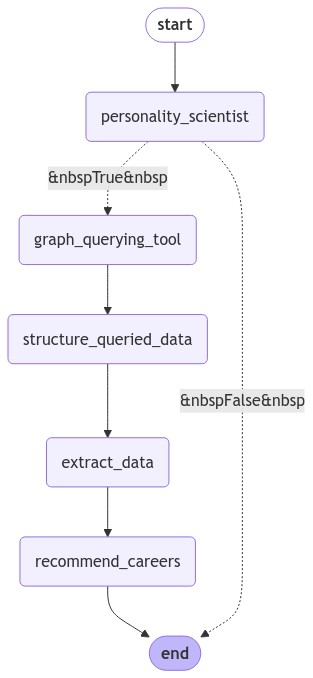

In [2]:
model = ChatGroq(temperature=0.8, groq_api_key=os.environ["GROQ_API_KEY"], model_name="llama-3.1-70b-versatile")
# model = ChatGroq(temperature=0.8, groq_api_key=os.environ["GROQ_API_KEY"], model_name="llama3-70b-8192")

agent = Agent(model=model, tools=[query_graph], system=prompts.personality_scientist_prompt.format(schema=graph.structured_schema))

In [5]:
thread = {'configurable': {'thread_id': "4"}}
output = agent.graph.stream({"conversation": [HumanMessage(content="first option")]}, thread, stream_mode='values')

for message in output:
    message['conversation'][-1].pretty_print()

================================ Human Message =================================

first option
================================== Ai Message ==================================
Tool Calls:
  query_graph (call_k6fg)
 Call ID: call_k6fg
  Args:
    query: MATCH (n:Occupation)-[]->(m:Personality_Trait) return n,m
Calling: query_graph

---- Tool Use Update ----> query is unique

Back to the model!
================================== Ai Message ==================================
Tool Calls:
  query_graph (call_k6fg)
 Call ID: call_k6fg
  Args:
    query: MATCH (n:Occupation)-[]->(m:Personality_Trait) return n,m
================================== Ai Message ==================================
Tool Calls:
  query_graph (call_k6fg)
 Call ID: call_k6fg
  Args:
    query: MATCH (n:Occupation)-[]->(m:Personality_Trait) return n,m
================================== Ai Message ==================================
Tool Calls:
  query_graph (call_k6fg)
 Call ID: call_k6fg
  Args:
    query: MATCH (n:Occup

In [11]:
state = agent.graph.get_state(thread).values


# len(state['tool_messages'][-1]), len(state['cypher_code_and_query_outputs'])
# print(f"tool_messages: {len(state['tool_messages'][-1])}, num_queries_made: {state['num_queries_made']}")

# state['conversation'][-2].additional_kwargs['tool_calls']
# state['conversation']
state['num_queries_made']
# state['query_is_unique']
state['extracted_data']
# state['tool_messages']
# state['cypher_code_and_query_outputs']
# state['query_is_unique']

state['extracted_data'][-1]

"[['Food_Servers,_Nonrestaurant', 'need_for_personality_trait', 'Conventional'], \n ['Animal_Caretakers', 'need_for_personality_trait', 'Conventional'], \n ['Waiters_and_Waitresses', 'need_for_personality_trait', 'Conventional'], \n ['Ushers,_Lobby_Attendants,_and_Ticket_Takers', 'need_for_personality_trait', 'Conventional'], \n ['Travel_Guides', 'need_for_personality_trait', 'Conventional'], \n ['School_Bus_Monitors', 'need_for_personality_trait', 'Conventional'], \n ['Psychiatric_Aides', 'need_for_personality_trait', 'Conventional'], \n ['Physical_Therapist_Aides', 'need_for_personality_trait', 'Conventional'], \n ['Personal_Care_Aides', 'need_for_personality_trait', 'Conventional'], \n ['Hosts_and_Hostesses,_Restaurant,_Lounge,_and_Coffee_Shop', 'need_for_personality_trait', 'Conventional'], \n ['Home_Health_Aides', 'need_for_personality_trait', 'Conventional'], \n ['Childcare_Workers', 'need_for_personality_trait', 'Conventional'], \n ['Dining_Room_and_Cafeteria_Attendants_and_Bart

In [16]:
results = ast.literal_eval(node_or_string=state['extracted_data'][-1])

head = []
tail = []
relation = []


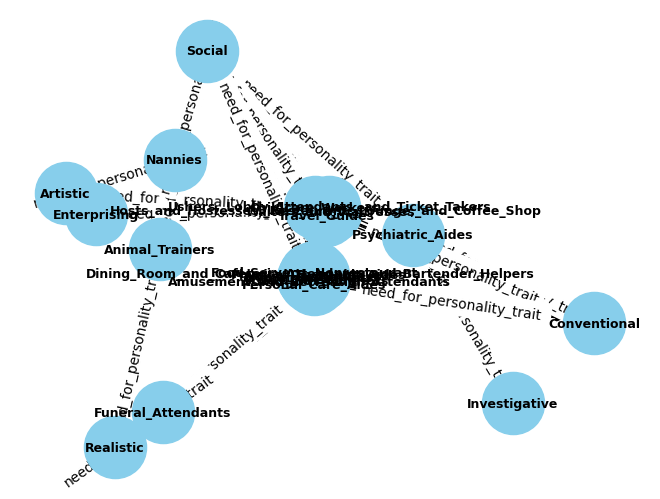

In [20]:
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
import matplotlib.pyplot as plt


G = nx.DiGraph()

for result in results:

    head = result[0]
    relation = result[1]
    tail = result[2]
    
    G.add_edge(head, tail, label=relation)

pos = nx.spring_layout(G, seed=42)

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=2000, font_size=9, font_color="black", font_weight="bold", arrows=True)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show plot
plt.show()

In [33]:
import pandas as pd
import networkx as nx
import plotly.graph_objects as go

def create_extracted_traits_graph(data):
  heads = []
  tails = []
  relations = []
  
  for row in data:
    head = row[0]
    relation = row[1]
    tail = row[2]
    
    heads.append(head)
    tails.append(tail)
    relations.append(relation)

  df = pd.DataFrame({'head': heads,  'tail': tails, 'relation': relations})

  G = nx.Graph()
  for _, row in df.iterrows():
    G.add_edge(row['head'], row['tail'], label="")

  # Get positions for nodes
  pos = nx.fruchterman_reingold_layout(G, k=0.5)

  # Create edge traces
  edge_traces = []
  for edge in G.edges():
      x0, y0 = pos[edge[0]]
      x1, y1 = pos[edge[1]]
      edge_trace = go.Scatter(
          x=[x0, x1, None],
          y=[y0, y1, None],
          mode='lines',
          line=dict(width=0.5, color='gray'),
          hoverinfo='none'
      )
      edge_traces.append(edge_trace)

  # Create node trace
  node_trace = go.Scatter(
      x=[pos[node][0] for node in G.nodes()],
      y=[pos[node][1] for node in G.nodes()],
      mode='markers+text',
      marker=dict(size=10, color='lightblue'),
      text=[node for node in G.nodes()],
      textposition='top center',
      hoverinfo='text',
      textfont=dict(size=7)
  )

  # Create edge label trace
  edge_label_trace = go.Scatter(
      x=[(pos[edge[0]][0] + pos[edge[1]][0]) / 2 for edge in G.edges()],
      y=[(pos[edge[0]][1] + pos[edge[1]][1]) / 2 for edge in G.edges()],
      mode='text',
      text=[G[edge[0]][edge[1]]['label'] for edge in G.edges()],
      textposition='middle center',
      hoverinfo='none',
      textfont=dict(size=7)
  )

  # Create layout
  layout = go.Layout(
      title='Knowledge Graph',
      titlefont_size=16,
      title_x=0.5,
      showlegend=False,
      hovermode='closest',
      margin=dict(b=20, l=5, r=5, t=40),
      xaxis_visible=False,
      yaxis_visible=False
  )

  # Create Plotly figure
  fig = go.Figure(data=edge_traces + [node_trace, edge_label_trace], layout=layout)

  return fig

create_plotly_graph(results)

In [ ]:
def extract_labels_from_query(cypher_code):
  # Extract start index and end index of the labels example: (n:Occupation) => start is ( end is )
  start = []
  end = []
  for i, character in enumerate(cypher_code):
    if character == "(": start.append(i+1)
    if character == ")": end.append(i)

  # Extract the labels using the start and end indicies. return labels as {'n': 'Occupation'...}
  labels = {}
  for i in range(len(start)):
    label = cypher_code[start[i]: end[i]] # returns "n:Occupation"
    label = label.split(":") # returns ["n", "Occupation"]

    labels[label[0]] = label[1]

  return labels


def organize_queried_data(data, labels):
  structured_queried_data = {'labels': list(labels.values()), 'relations': []}

  for i in range(len(data)):
    # extract keys (nodes' refrences as they were returned from the query's output. example: "cypher code ... return n,m")
    row = data[i]
    keys = list(row.keys()) # keys are the referenced labels. example: n:Occupation, so n is referencing Occupation
    
    # Extract node relations. example: Occupation: Teacher, Personality_Trait: Social
    
    relation = []
    for i in range(len(keys)):
      key = keys[i]
      # label = labels[key]
      properties = row[key]
      
      relation.append(properties)

    structured_queried_data['relations'] += [relation]
  
  return structured_queried_data

query_output = ast.literal_eval(state['cypher_code_and_query_outputs'][0]['output'])
llm_query = state['cypher_code_and_query_outputs'][0]['cypher_code']

labels = extract_labels_from_query(cypher_code=llm_query)
outputs = organize_queried_data(data=query_output, labels=labels)
outputs